In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://huggingface.co/datasets/OCR-Ethiopic/HHD-Ethiopic


Cloning into 'HHD-Ethiopic'...
remote: Enumerating objects: 742, done.
remote: Total 742 (delta 0), reused 0 (delta 0), pack-reused 742 (from 1)
Receiving objects: 100% (742/742), 2.03 MiB | 2.86 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Filtering content: 100% (349/349), 227.52 MiB | 12.31 MiB/s, done.


In [ ]:
!unzip /content/HHD-Ethiopic/train/train_numpy.zip

Archive:  /content/HHD-Ethiopic/train/train_numpy.zip
   creating: train_numpy/
  inflating: train_numpy/y_train.npy  
  inflating: train_numpy/x_train.npy  
  inflating: train_numpy/dictionary.txt  


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import cv2
import json
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from jiwer import wer, cer
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image
import torchvision

In [ ]:
images =  os.listdir("/content/HHD-Ethiopic/train/train_raw/image_train")
text =  os.listdir("/content/HHD-Ethiopic/train/train_raw/gt_train")

print(len(images), len(text))

100 100


In [ ]:
x = np.load("train_numpy/x_train.npy", allow_pickle=True)
y = np.load("train_numpy/y_train.npy", allow_pickle=True)

In [ ]:
# Split into 80% training and 20% validation
x, x_val, y, y_val = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)


In [ ]:
import json
import re

# Read the file
with open('/content/drive/MyDrive/dictionary.txt', encoding="utf-8") as json_file:
    raw_data = json_file.read()

# Convert integer keys to string keys using regex
raw_data = re.sub(r'(\d+):', r'"\1":', raw_data)  # Wrap numbers in double quotes
fixed_data = raw_data.replace("'", '"')
# Parse as JSON
data = json.loads(fixed_data)

# Save the fixed JSON
fixed_file_path = "/content/HHD-Ethiopic/dictionary_fixed.json"
with open(fixed_file_path, "w", encoding="utf-8") as json_file:
    json.dump(data, json_file, ensure_ascii=False, indent=4)


In [ ]:
# Read the file
with open('/content/HHD-Ethiopic/dictionary_fixed.json', encoding="utf-8") as json_file:
    raw_data = json_file.read()
raw_data = json.loads(raw_data)
raw_data["307"] = "<sos>"

In [ ]:
for (k,v) in raw_data.items():
  # print(k,v)
  if v == "፡":
    print(k)

279


In [ ]:
def id_to_char(ids):
  return ''.join([raw_data[str(id)] for id in ids if id != 0])
def get_input(ids):
  return [id.item() for id in ids[1:]]
def get_len(ids):
  return len([raw_data[str(id.item())] for id in ids if id != 0])

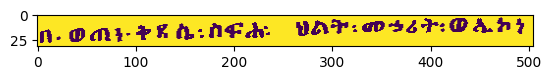

In [ ]:
plt.imshow(x[1000]) # dsize=(224, 96)
# print(y[100], id_to_char(y[100]))

In [ ]:
print(y.shape, len(raw_data))

(45899, 46) 306


In [ ]:
class MyOcrDataloader:
    def __init__(self, x_images,y_text, ):

        self.x_images=  x_images
        self.y_text=  y_text

        assert len(self.x_images) == len(self.y_text)
        self.n_data_points = len(self.x_images)

    def __len__(self):
        return self.n_data_points

    def __getitem__(self, idx):

        image = self.x_images[idx]
        text = self.y_text[idx]
        image = cv2.resize(image/255.0, dsize=(224, 224))


        return torch.tensor(image), torch.tensor(text)

    def __iter__(self):
        self.idx = 0
        return self

    def __next__(self):
        if self.idx >= self.n_data_points:
            self.idx = 0
            raise StopIteration
        self.idx += 1
        return self[self.idx] ## calling the

    def collate_fn(self, batch):
        texts = batch[1]
        lengths_transcript = [get_len(data[1])  for data in batch]


        images  = torch.stack([data[0] for data in batch ], dim=0)
        texts  = torch.stack([data[1][1:] for data in batch ], dim=0)
        input_texts  = ([[307] + get_input(data[1])[:-1]  for data in batch]) ##307 is SOS, 0 is pad token
        input_texts  =torch.tensor(input_texts)
        return images, input_texts, texts, torch.tensor(lengths_transcript)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "pa

In [ ]:
data = MyOcrDataloader(x[:1000], y[:1000])
val_data = MyOcrDataloader(x_val[:100], y_val[:100])

train_loader = torch.utils.data.DataLoader(
    dataset     = data,
    batch_size  = 32,
    collate_fn= data.collate_fn,
    num_workers=4,
    shuffle     = True,
    )
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 32,
    collate_fn= data.collate_fn,
    shuffle     = True,
    )


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
for batch_idx, (images, input_texts, target_texts, lengths) in enumerate(val_loader):
    # print(images.shape, input_texts.shape, "--", target_texts.shape, )
    # print("input", input_texts[0], "len", lengths[0])
    # print("output", target_texts[0])
    # images = images.unsqueeze(1)
    # image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
    # images =images.unsqueeze(1).repeat(1, 3, 1, 1)
    # pixel_values = processor(images, return_tensors="pt").pixel_values.to(device)
    # with torch.inference_mode():
    #   out = model.encoder(pixel_values)
    # print(out.shape)
    break

In [ ]:
# out["last_hidden_state"]
out["last_hidden_state"].shape

torch.Size([32, 577, 768])

In [ ]:
import torch
import torch.nn as nn
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

class TransformerDecoder(nn.Module):
    def __init__(self, d_model, nhead, num_decoder_layers, dim_feedforward, num_classes):
        super(TransformerDecoder, self).__init__()

        # Embedding layer for input texts
        self.embedding = nn.Embedding(num_classes, d_model)

        # Positional encoding for text sequences
        self.positional_encoding = nn.Parameter(torch.zeros(1, 45, d_model))  # Max sequence length of 100

        # Transformer decoder
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                batch_first=True
            ),
            num_layers=num_decoder_layers
        )

        # Fully connected layer for final output
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, encoded_features, input_texts):
        # Embed input texts
        tgt = self.embedding(input_texts)  # Shape: (batch_size, seq_len, d_model)

        # Add positional encoding to the decoder input
        tgt = tgt + self.positional_encoding[:, :tgt.size(1), :]

        # Transformer decoder forward pass
        decoder_output = self.transformer_decoder(tgt, encoded_features)  # Shape: (batch_size, seq_len, d_model)

        # Fully connected layer for final output
        out = self.fc(decoder_output)  # Shape: (batch_size, seq_len, num_classes)

        return out


class ImageTextTransformer(nn.Module):
    def __init__(self, trocr_model_name, num_decoder_layers, nhead, dim_feedforward, num_classes):
        super(ImageTextTransformer, self).__init__()

        # Load TrOCR model (encoder only)
        self.processor = TrOCRProcessor.from_pretrained(trocr_model_name)
        self.encoder = VisionEncoderDecoderModel.from_pretrained(trocr_model_name).encoder

        # Extract `d_model` from TrOCR encoder
        d_model = self.encoder.config.hidden_size

        # Text Transformer decoder
        self.text_decoder = TransformerDecoder(
            d_model=d_model,
            nhead=nhead,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            num_classes=num_classes
        )

    def forward(self, images, input_texts):
        # Preprocess images with TrOCR processor
        pixel_values = self.processor(images, return_tensors="pt").pixel_values.to(next(self.encoder.parameters()).device)

        # Encode images using TrOCR encoder
        with torch.inference_mode():
            encoded_features = self.encoder(pixel_values)["last_hidden_state"]  # Shape: (batch_size, num_patches+1, d_model)

        # Decode text using Transformer decoder
        output = self.text_decoder(encoded_features, input_texts)  # Shape: (batch_size, seq_len, num_classes)

        return output


In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from torchmetrics.text import CharErrorRate, WordErrorRate

def train_epoch(model, train_loader, criterion, optimizer, device, num_classes):
    model.train()
    running_loss = 0.0
    cer = CharErrorRate().to(device)
    cer.reset()

    for batch_idx, (images, input_texts, target_texts, lengths) in enumerate(train_loader):
        optimizer.zero_grad()

        # Move data to device'
        images =images.unsqueeze(1).repeat(1, 3, 1, 1)


        images = images.to(device)
        input_texts = input_texts.to(device)
        target_texts = target_texts.to(device)

        # Forward pass
        outputs = model(images, input_texts)
        preds = torch.argmax(outputs, dim=2)
        outputs = outputs.view(-1, num_classes)

        # Calculate loss
        loss = criterion(outputs, target_texts.view(-1).long())

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # cer = 0
        # Print metrics every 1000 batches
        if batch_idx % 20 == 0:
            pred_text = []
            target_text = []

            for pred, target in zip(preds.tolist(), target_texts.tolist() ):
              target_text.append(id_to_char(target))
              pred_text.append(id_to_char(pred))
            for i in range(5):
              print("pred ", pred_text[i], "== target ", target_text[i])
            print(f'Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {running_loss/(batch_idx+1):.4f}, '
                  f'CER: {cer(target_text,pred_text ):.4f}')

    return running_loss / len(train_loader)

def validate(model, val_loader, criterion, device, num_classes):
    model.eval()
    total_loss = 0.0
    cer = CharErrorRate().to(device)
    # wer = WordErrorRate().to(device)

    with torch.no_grad():
        for batch_idx, (images, input_texts, target_texts, lengths) in enumerate(val_loader):
            # Move data to device
            images = images.repeat(1, 3, 1, 1)

            images = images.to(device)
            input_texts = input_texts.to(device)
            target_texts = target_texts.to(device)

            # Forward pass
            outputs = model(images, input_texts)
            preds = torch.argmax(outputs, dim=2)
            outputs = outputs.view(-1, num_classes)

            # Calculate loss
            loss = criterion(outputs, target_texts.view(-1).long())
            total_loss += loss.item()

            # Update metrics
            # wer.update(preds.unsqueeze(0), target_texts.unsqueeze(0))
                    # Print metrics every 100 batches
            # cer.reset()
            # if batch_idx % 5 == 0:
            #     cer.update(preds, target_texts)
            #     print(f'Val Batch [{batch_idx+1}/{len(val_loader)}], '
            #           f'Val Loss: {total_loss/(batch_idx+1):.4f}, '
            #           f'Val CER: {cer.compute():.4f}')
            #     for pred, target in zip(preds[:4,:10].tolist(), target_texts[:4, :10].tolist() ):
            #         print(id_to_char(pred), id_to_char(target))
    avg_loss = total_loss / len(val_loader)
    return avg_loss, cer.compute()


In [ ]:

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameters
cnn_output_dim = 5376
lstm_hidden_dim = 128
lstm_num_layers = 2
num_classes = 308

# Initialize model
# model = CNNLSTM(cnn_output_dim, lstm_hidden_dim, lstm_num_layers, num_classes).to(device)
# model  = ResNetLSTM(lstm_hidden_dim, lstm_num_layers, num_classes).to(device)
# Initialize the ImageTextTransformer
trocr_model_name = "microsoft/trocr-base-handwritten"
num_decoder_layers = 2
nhead = 4
dim_feedforward = 2048
num_classes = 308  # Default tokenizer vocab size for TrOCR


model = ImageTextTransformer(trocr_model_name, num_decoder_layers, nhead, dim_feedforward, num_classes).to(device)

print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

weights = torch.ones(num_classes)
weights[0] = 0
weights[278] = 0

weights = weights.to(device)
# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(ignore_index=0, weight = weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
optimizer, mode='min', factor=0.5, patience=1, verbose=True
)

# Training parameters
num_epochs = 100
best_val_loss = float("inf")
best_model_path = "/content/drive/MyDrive/best_model.pth"

# Training loop
for epoch in range(num_epochs):

  # Training phase
  train_loss = train_epoch(
      model, train_loader, criterion, optimizer, device, num_classes
  )

  # # Validation phase (every 2 epochs)
  # if (epoch>0 ) and (epoch + 1) % 5 == 0:
  #     val_loss, val_cer = validate(
  #         model, val_loader, criterion, device, num_classes
  #     )

  #     print(f'Epoch [{epoch+1}/{num_epochs}]')
  #     print(f'Training Loss: {train_loss:.4f}')
  #     print(f'Validation Loss: {val_loss:.4f}')
  #     print(f'Validation CER: {val_cer:.4f}')
  #     # print(f'Validation WER: {val_wer:.4f}')

  #     # Learning rate scheduling
  #     scheduler.step(val_loss)

      # # Save best model
      # if val_loss < best_val_loss:
      #     best_val_loss = val_loss
      #     torch.save(model.state_dict(), best_model_path)
      #     print(f'Saved best model with validation loss: {best_val_loss:.4f}')


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.1"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

Total trainable parameters: 102,917,172
pred  ኙኈኵቷኙጣጣኙጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣኙጣጣጣጣጣጣጣጣጣጣጣጣጣ == target  ዶሞስ
pred  ሾኪሐቍቷዊፐኩኙኩጣቷዪኙዲሿጣጣጣጣጣኙጣጣጣጣጣጣጣኙጣጣጣጣጣጣጣጣኙጣጣጣጣጣጣ == target  ደ፡ረአኮ፡ለርለሰነ፡ዘሰበ
pred  ሾጣሸጃዦኊጯሒዢኩፋሞፐኈዌዦዒጯሐኡኊዴጶኳዌኴኽዌጤኈዌጼጣኙጣጣጣጣጣጣጣጣጣጣኙ == target  ያድኅነኪ፡አምላከኪ፡አንተስ፡እግዚኦ፡ምስከይየ፡አንተ
pred  ኩሲዤኳጣጣጣኙጣጣጣጣጣጣጣጣጣኙኙኙጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣኙጣጣጣጣጣኙጣጣ == target  ዓመ፡
pred  ርፋፃኩፐሐዤዒኊዌጣኙጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣጣኙጣጣጣጣጣጣ == target  ኡዘዙ፡ወይስእሉ
Batch [1/32], Loss: 5.9542, CER: 0.9986
pred  ፡፡በ፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡ == target  ነ፡በ
pred  ፡፡ወ፡፡፡፡፡፡፡፡እ፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡ == target  ሉ፡የሽደርጉለታል፡ወንጌለኛ
pred  ፡፡፡፡፡፡፡፡፡፡ወ፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡ == target  ነፍስየ።ወትቤሎ፡አ
pred  ፡፡፡፡ወ፡፡፡፡ወ፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡ == target  ንሣኤ፡ሕይወት፡ወ
pred  ፡፡፡እ፡፡፡እ፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡ == target  ንዘ፡ይብሉ፡እግዚ
Batch [21/32], Loss: 4.3466, CER: 0.9306
pred  ፡ወ፡፡፡ወ፡፡፡፡ወእ፡፡፡፡ወ፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡ == target  ፡ጸልዩ፡ለዘጸሐ፡ወበጸሎተ፡ኩሎሙ
pred  ፡ወእ፡፡፡፡ወ፡፡ዚ፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡፡

In [ ]:
# from torchmetrics import CharErrorRate, WordErrorRate
# cnn_output_dim = 5376  # This should match the output dimension of your CNN
# lstm_hidden_dim = 128
# lstm_num_layers = 2
# num_classes = 308  # Number of classes (including padding and SOS token)

# model = CNNLSTM(cnn_output_dim, lstm_hidden_dim, lstm_num_layers, num_classes)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding tokens
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# cer = CharErrorRate()
# wer = WordErrorRate()

# # Training loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0

#     for batch_idx, (images, input_texts, target_texts, lengths) in enumerate(train_loader):
#         # print(input_texts.shape, target_texts.shape)


#         optimizer.zero_grad()

#         # Forward pass
#         images = images.unsqueeze(1).float()  # Add channel dimension
#         outputs = model(images, input_texts)  # Pass input_texts to the model

#         # Reshape outputs and target_texts for loss calculation
#         outputs = outputs.view(-1, num_classes)
#         # print(outputs.shape, target_texts.shape)
#         target_texts = target_texts.view(-1)
#         # Compute loss
#         loss = criterion(outputs, target_texts.long())

#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         # Update running loss
#         running_loss += loss.item()

#         # Compute CER and WER
#         preds = torch.argmax(outputs, dim=1)
#         # print(preds, target_texts)
#         cer.update(preds.unsqueeze(0), target_texts.unsqueeze(0))
#         # wer.update(preds.unsqueeze(0), target_texts.unsqueeze(0))

#         if batch_idx % 100 == 99:  # Print every 100 batches
#             # print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}, CER: {cer.compute():.4f}, WER: {wer.compute():.4f}')
#             print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}, CER: {cer.compute():.4f},')

#             running_loss = 0.0
#             cer.reset()
#             # wer.reset()

#     print(f'Epoch [{epoch+1}/{num_epochs}] finished, Loss: {running_loss/len(train_loader):.4f}, CER: {cer.compute():.4f}, WER: {wer.compute():.4f}')

In [34]:
100* ((0.9600- 0.93628 ) /0.93628 )

2.533430170461824